In [20]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from keras.applications.vgg16 import VGG16

from xgboost import XGBClassifier

In [4]:
#Load dataset
df_train = pd.read_json("D:/StatoilC-CORE Iceberg Classifier Challenge/train.json/train.json")
df_train.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [5]:
def prepare_data(df):
    X_band_1 = []
    X_band_2 = []
    
    for band in df["band_1"]:
        #Convert to float32
        band_1 = np.array(band).astype(np.float32)
        #Reshaping band_1 and band_2
        band_1 = band_1.reshape(75,75)
        X_band_1.append(band_1)
        
    for band in df["band_2"]:
         #Convert to float32
        band_2 = np.array(band).astype(np.float32)
        #Reshaping band_1 and band_2
        band_2 = band_2.reshape(75,75)
        X_band_2.append(band_2)
        
    #Convert list to numpy array
    X_band_1 = np.array(X_band_1)
    X_band_2 = np.array(X_band_2)
    
    # Rescale
    X_band_1 = (X_band_1 - X_band_1.mean()) / (X_band_1.max() - X_band_1.min())
    X_band_2 = (X_band_2 - X_band_2.mean()) / (X_band_2.max() - X_band_2.min())
    
    #Concatenate band_1 and band_2 to create X for training (or test)
    X = np.concatenate([X_band_1[:, :, :, np.newaxis], 
                        X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], 
                        axis=-1)
     
    return X

In [6]:
X = prepare_data(df_train)
Y = np.array(df_train["is_iceberg"])

print("X shape is:{}".format(X.shape))
print("Y shape is:{}".format(Y.shape))

X shape is:(1604, 75, 75, 3)
Y shape is:(1604,)


# Transfer learning using VGG16

In [7]:
SIZE = 75

# Split data to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("X_train shape is:{}".format(X_train.shape))
print("Y_train shape is:{}".format(Y_train.shape))
print("X_test shape is:{}".format(X_test.shape))
print("Y_test shape is:{}".format(Y_test.shape))

X_train shape is:(1283, 75, 75, 3)
Y_train shape is:(1283,)
X_test shape is:(321, 75, 75, 3)
Y_test shape is:(321,)


In [8]:
# Normalize and reshape
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train = X_train / 255
X_test = X_test / 255

In [9]:
# Now load vgg16 model without fully connected layer
vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(SIZE, SIZE, 3))

In [10]:
# Make loaded layers non-trainable
# Trainable layers will be equal to 0
for layer in vgg_model.layers:
    layer.trainable = False
    
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0     

In [11]:
# Now we want to use feature extarctor of vgg model for XGBoost model
feature_vgg16 = vgg_model.predict(X_train)
features = feature_vgg16.reshape(feature_vgg16.shape[0], -1)

# exactly the same process for testing data
feature_for_Xtest = vgg_model.predict(X_test)
X_test_features = feature_for_Xtest.reshape(feature_for_Xtest.shape[0], -1)

# features extracted from vgg model is going to be X for XGbosst
X_training = features

## XGBoost Image Classification

In [13]:
model = XGBClassifier()
# For sklearn model we do not need one-hot encoding for Y
model.fit(X_training, Y_train)

C:\Users\VHD\anaconda3\envs\SI\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
# Here, we predict XGB model using X_test_features
prediction = model.predict(X_test_features)

## Model Accuracy

In [18]:
accuracy = accuracy_score(Y_test, prediction)
print("Accuracy = {}".format(accuracy))

Accuracy = 0.7632398753894081


<AxesSubplot:>

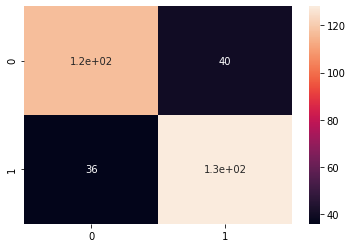

In [21]:
# Confusion matrix
cm = confusion_matrix(Y_test, prediction)
sns.heatmap(cm, annot=True)

In [22]:
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.76      0.75      0.75       157
           1       0.76      0.78      0.77       164

    accuracy                           0.76       321
   macro avg       0.76      0.76      0.76       321
weighted avg       0.76      0.76      0.76       321



The prediction for this image is:  0
The actual label for this image is:  1


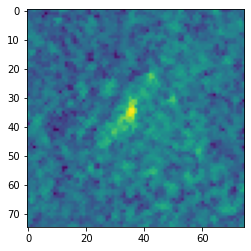

In [27]:
#Check results on a few select images
num = np.random.randint(0, X_test.shape[0])
img = X_test[num]
plt.imshow(img[:,:,0])
#Expand dimension so the input is (num images, x, y, c)
input_img = np.expand_dims(img, axis=0) 
img_feature = vgg_model.predict(input_img)
img_features = img_feature.reshape(img_feature.shape[0], -1)
y_pred = model.predict(img_features)[0] 
print("The prediction for this image is: ", y_pred)
print("The actual label for this image is: ", Y_test[num])

The prediction for this image is:  0
The actual label for this image is:  0


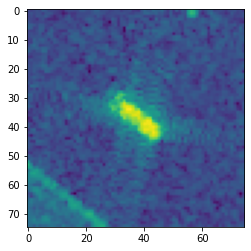

In [25]:
#Check results on a few select images
num = np.random.randint(0, X_test.shape[0])
img = X_test[num]
plt.imshow(img[:,:,0])
#Expand dimension so the input is (num images, x, y, c)
input_img = np.expand_dims(img, axis=0) 
img_feature = vgg_model.predict(input_img)
img_features = img_feature.reshape(img_feature.shape[0], -1)
y_pred = model.predict(img_features)[0] 
print("The prediction for this image is: ", y_pred)
print("The actual label for this image is: ", Y_test[num])